In [1]:
%matplotlib inline
import pandas as pd

In [2]:
compras_df = pd.read_csv('./data/compras_df_enriched.csv')

In [3]:
compras_df.head()

,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,DAY,MONTH,YEAR,BENEFICIARIO_SALES,IMPORTE_GASTO_PROMEDIO,HAS_LINKEDIN_SITE
0,110152,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS AF8458-158008-3972,OT. 20204373,REEMPLAZO E INSTALACION DE AMORTIGUADORES (DEL...,TR,1019110.0,2020-12-11,14911.80,GASTOS VARIOS,11,12,2020,13,881659.731797,True
1,110152,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF6916-158008-4041,OT. 20204425,REEMPLAZO E INSTALACION DE OCHO BIRLOS Y NUEVE...,TR,1019110.0,2020-12-11,2528.80,GASTOS VARIOS,11,12,2020,13,881659.731797,True
2,110152,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF6917-158008-3975,OT. 20204376,REEMPLAZO DE DOS RINES (17). PATRIMONIO 80383...,TR,1019110.0,2020-12-11,8500.02,GASTOS VARIOS,11,12,2020,13,881659.731797,True
3,110152,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF7004-158008-3971,OT. 20204374,REEMPLAZO DE DOS RINES (14). PATRIMONIO 8007...,TR,1019110.0,2020-12-11,2400.01,GASTOS VARIOS,11,12,2020,13,881659.731797,True
4,110152,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF7137-158008-4554,OT. 20205130,REEMPLAZO E INSTALACION DE RIN 14. PATRIMONIO ...,TR,299001496.0,2020-12-23,1537.00,GASTOS VARIOS,23,12,2020,13,881659.731797,True


## Trying a supervised model

In [4]:
data = compras_df.copy()

In [5]:
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
        data[data.columns[i]] = data[data.columns[i]].astype("category").cat.codes
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

In [6]:
data.head()

,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,DAY,MONTH,YEAR,BENEFICIARIO_SALES,IMPORTE_GASTO_PROMEDIO,HAS_LINKEDIN_SITE
0,110152,161,167,1388,130,780,1,1019110.0,8,14911.80,2,11,12,2020,13,881659.731797,True
1,110152,161,167,1389,135,845,1,1019110.0,8,2528.80,2,11,12,2020,13,881659.731797,True
2,110152,161,167,1390,132,759,1,1019110.0,8,8500.02,2,11,12,2020,13,881659.731797,True
3,110152,161,167,1391,131,757,1,1019110.0,8,2400.01,2,11,12,2020,13,881659.731797,True
4,110152,161,167,1392,417,859,1,299001496.0,16,1537.00,2,23,12,2020,13,881659.731797,True


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [8]:
y = data.pop('IMPORTE')
X = data.copy()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
clf = RandomForestRegressor(n_estimators=1000, max_depth=4)

In [11]:
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

In [12]:
from sklearn.metrics import r2_score

In [13]:
r2_score(y_test, clf.predict(X_test))

0.18765412819044747

## Trying a non supervised model clustering text

In [14]:
import gensim
from nltk.corpus import stopwords
import numpy as np
np.random.seed(2021)

In [16]:
def preprocess(text):
    result = []
    for token in text.split():
        if token not in stopwords.words('spanish') and len(token)>4:
            result.append(token)
    return result

In [17]:
process_business = [preprocess(x) for x in list(compras_df['BENEFICIARIO'].unique())]

In [20]:
dictonary = gensim.corpora.Dictionary(process_business)

In [22]:
dictonary.filter_extremes(no_below=1, no_above=0.5)

In [23]:
bow_corpus = [dictonary.doc2bow(doc) for doc in process_business]

In [24]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=dictonary, passes=10, workers=2)

In [26]:
for idx, type_business in lda_model.print_topics(-1):
    print('Topic:{} words:{}'.format(idx, type_business))

Topic:0 words:0.010*"DESARROLLOS" + 0.010*"GARZA" + 0.010*"GUERRERO" + 0.010*"INSTITUTO" + 0.010*"SALAZAR" + 0.010*"ADRIANA" + 0.010*"BANCO" + 0.010*"URBANIZACIONES" + 0.010*"IGNACIO" + 0.010*"JESUS"
Topic:1 words:0.033*"GARCIA" + 0.021*"GONZALEZ" + 0.021*"GARZA" + 0.018*"MARIA" + 0.013*"TREVIÑO" + 0.013*"SANCHEZ" + 0.013*"MARCELO" + 0.013*"ARTURO" + 0.013*"MANUEL" + 0.009*"ALBERTO"
Topic:2 words:0.015*"GRUPO" + 0.010*"SERVICIOS" + 0.010*"ESTHER" + 0.010*"MARTINEZ" + 0.010*"MONTERREY" + 0.010*"CONSTRUCTORA" + 0.010*"MORENO" + 0.005*"ALEJANDRO" + 0.005*"VILLARREAL" + 0.005*"HERNANDEZ"
Topic:3 words:0.026*"MARIA" + 0.023*"RODRIGUEZ" + 0.019*"GONZALEZ" + 0.018*"GOMEZ" + 0.012*"LOZANO" + 0.008*"TORRES" + 0.008*"DESARROLLO" + 0.008*"PEREZ" + 0.008*"SEGURIDAD" + 0.008*"SANCHEZ"
Topic:4 words:0.031*"CONSTRUCTORA" + 0.018*"CONSTRUCCIONES" + 0.018*"MEXICO," + 0.010*"NUEVO" + 0.010*"RAMIREZ" + 0.010*"SEGUROS" + 0.010*"INTEGRACION" + 0.010*"SEBASTIAN," + 0.010*"ARRENDADORA" + 0.010*"GRUPO"
Topic:

In [27]:
def get_max_topic(index):
    results = lda_model[bow_corpus[index]]
    return max(lda_model[results], key=lambda x: x[1])[0]

In [28]:
business_cluster = {x: get_max_topic(i) for i, x in enumerate(list(compras_df['BENEFICIARIO'].unique()))}

In [30]:
compras_df['CLUSTER_NAME'] = compras_df['BENEFICIARIO'].apply(lambda x: business_cluster[x])

<Axes: xlabel='CLUSTER_NAME'>

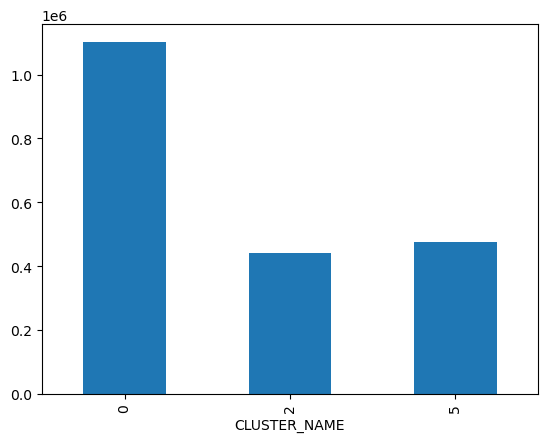

In [32]:
compras_df.groupby('CLUSTER_NAME')['IMPORTE'].mean().plot.bar()

## Trying a non supervised model anomalies